# CSCI 4140 Assignment Two

#### Introduction
Our current quantum computers have physical qubits and not logical qubits. We’ve developed
all of our algorithms using logical qubits, so they might not perform as well with noisy physical
qubits. In this assignment you will explore the impact of noise on one of the classical quantum
algorithms. The algorithm that I’ve selected is Grover’s algorithm, since you have already
implemented this algorithm in laboratory five. This assignment involves a little bit of
programming, but mainly consists of running two experiments investigating different ways noise
could impact this algorithm.
#### Noise Model
You will use the following noise model in this assignment:

In [20]:
def get_noise(p_meas, p_gate):
    error_meas = pauli_error([('X', p_meas),('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x", "h", "mct"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
    
    return noise_model

backend = Aer.get_backend('qasm_simulator')

This noise model is similar to ones that we have used before. The first parameter controls the
measurement error and the second parameter controls the gate error.

#### Problem Oracles
We will use two problem oracles, both of which are produced by the grover_problem_oracle
function that we used in laboratory five. The following table shows the parameters used to
create the two problem oracles for this assignment.

|Problem  | Bits | Variant|
|:---- |:----|:-----|
|Problem One| 4 | 0 |
|Problem Two| 5 | 2 |

You have seen both of these oracles in laboratory five. You can also use the **initialize_s** and
**diffuser** functions from that laboratory.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy import pi
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_histogram
from qiskit_textbook.problems import grover_problem_oracle
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import *

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    
    for qubit in range(nqubits):
        qc.h(qubit)
    
    for qubit in range(nqubits):
        qc.h(qubit)
        
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    
    for qubit in range(nqubits):
        qc.x(qubit)
    
    for qubit in range(nqubits):
        qc.h(qubit)
    
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

### Experiment One
Start by implement both the Grover problems without a noise model. This will give you the base
case for both experiments. You have already done this in laboratory five, so just copy your code
from there. Note the probability of getting the correct result for both of these problems

The first experiment involves investigating the impact of gate error rates on the two Grover
problems. 

Start with a noise model with 0.01 as the values for both the measurement error and
the gate error. 

What impact does this have on the result of Grover’s algorithm? 

Try several different gate error rates to find the error level where the result is within 10% of the result
obtained with no noise model.

Produce a table that has two rows, one for each of the Grover problems. The table has a column
for each of the gate error rates that you tried (there should be at least 4 of them). The table
entries contain the probability of the correct results, which you can read off of the histogram.
This is the first part of your assignment report.

Solutions:
|1101>


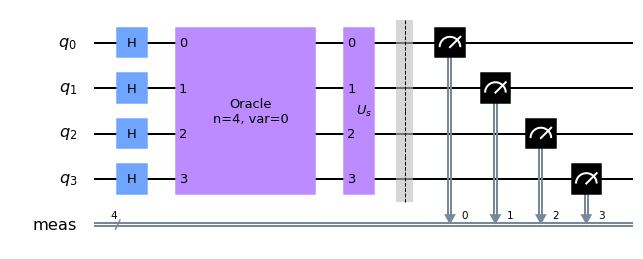

In [65]:
#Problem One
n = 4
variant = 0
oracle = grover_problem_oracle(n, variant, print_solutions = True)
qc = QuantumCircuit(n)
qc = initialize_s(qc, [0,1,2,3])
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.measure_all()
qc.draw('mpl')

{'0000': 432, '0001': 55, '0010': 28, '0011': 7, '0100': 93, '0101': 67, '0110': 8, '0111': 13, '1000': 89, '1001': 50, '1010': 21, '1011': 8, '1100': 71, '1101': 57, '1110': 11, '1111': 14}


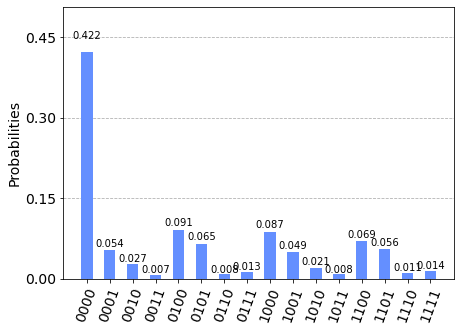

In [80]:
noise_model = get_noise(0.01, 0.01)
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)

{'0000': 564, '0001': 69, '0100': 62, '0101': 41, '1000': 66, '1001': 86, '1100': 61, '1101': 75}


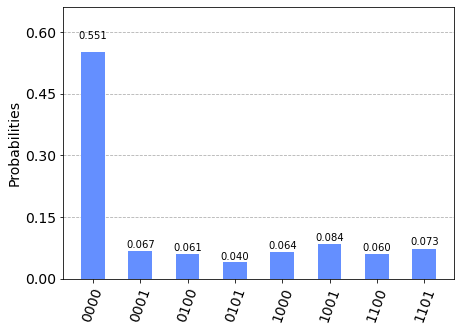

In [54]:
results = execute(qc, backend=backend, shots=1024).result().get_counts()
print(results)
plot_histogram(results)

Solutions:
|00100>


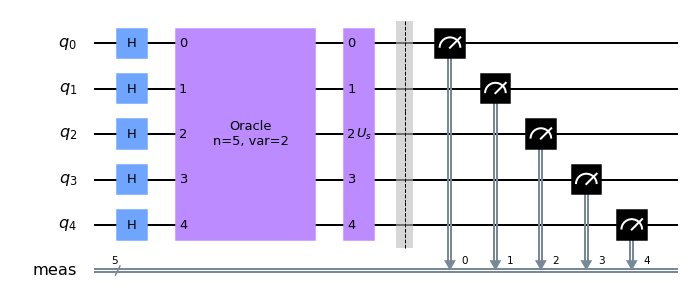

In [25]:
#Problem Two
n = 5
variant = 2
oracle = grover_problem_oracle(n, variant, print_solutions = True)
qc = QuantumCircuit(n)
qc = initialize_s(qc, [0,1,2,3,4])
qc.append(oracle, [0,1,2,3,4])
qc.append(diffuser(n), [0,1,2,3,4])
qc.measure_all()
qc.draw('mpl')

{'0000': 556, '0001': 70, '0100': 70, '0101': 43, '1000': 66, '1001': 69, '1100': 68, '1101': 82}


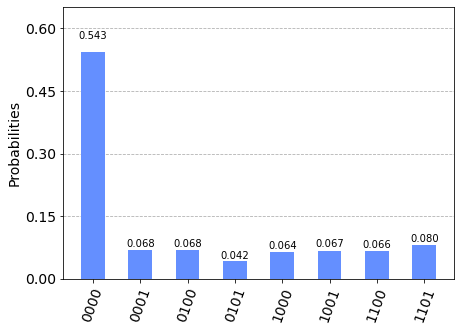

In [56]:
results = execute(qc, backend=backend, shots=1024).result().get_counts()
print(results)
plot_histogram(results)

{'0000': 360, '0001': 71, '0010': 55, '0011': 27, '0100': 85, '0101': 51, '0110': 18, '0111': 20, '1000': 90, '1001': 54, '1010': 18, '1011': 13, '1100': 59, '1101': 56, '1110': 28, '1111': 19}


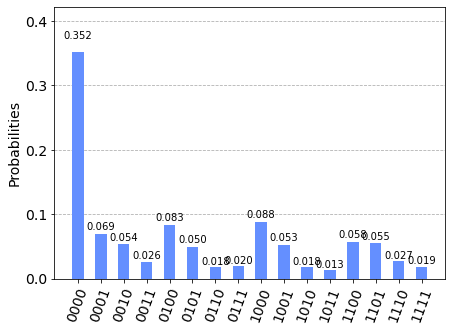

In [79]:
noise_model = get_noise(0.01, 0.01)
counts = execute(qc, backend, noise_model=noise_model).result().get_counts()
print(counts)
plot_histogram(counts)

### Experiment Two
Grover’s algorithm is an iterative algorithm where the two basic steps are repeated until a
solution is produced. 

Hypothesis: noise decreases the probability of obtaining the correct result,
so performing more iterations of Grover’s algorithm will produce a better result. In this part of
the assignment you will run an experiment to determine if this hypothesis is true.

This can be done by adding iterations to your program code from the first experiment. Each
iteration is two lines of code, so it is easy to cut and paste more iterations into the algorithm. Try
this to see what happens to the probability of obtaining the correct result as the number of
iterations increases. 

Is the hypothesis true? Why do you think this is the case? The second part
of the assignment report is your answers to these two questions.

Solutions:
|1101>


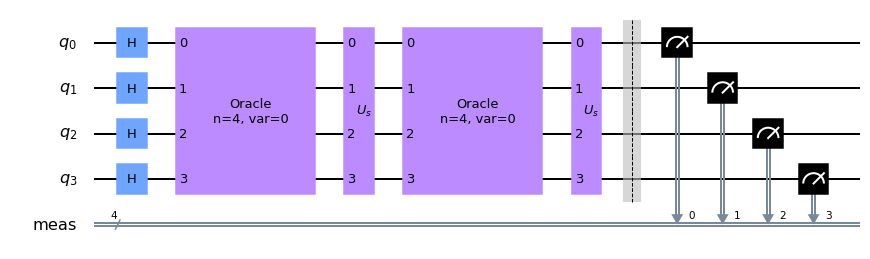

In [57]:
#Problem One
## Iteration X2
n = 4
variant = 0
oracle = grover_problem_oracle(n, variant, print_solutions = True)
qc = QuantumCircuit(n)
qc = initialize_s(qc, [0,1,2,3])
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.measure_all()
qc.draw('mpl')

{'0000': 9, '0001': 14, '0010': 33, '0011': 12, '0100': 16, '0101': 143, '0110': 14, '0111': 151, '1000': 22, '1001': 151, '1010': 12, '1011': 132, '1100': 124, '1101': 16, '1110': 158, '1111': 17}


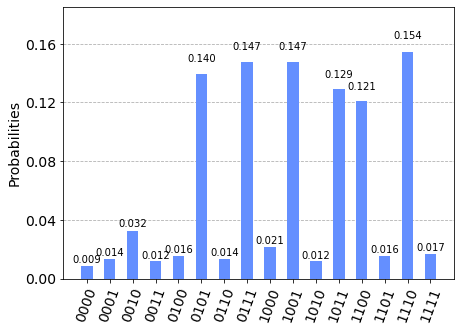

In [58]:
results = execute(qc, backend=backend, shots=1024).result().get_counts()
print(results)
plot_histogram(results)

Solutions:
|1101>


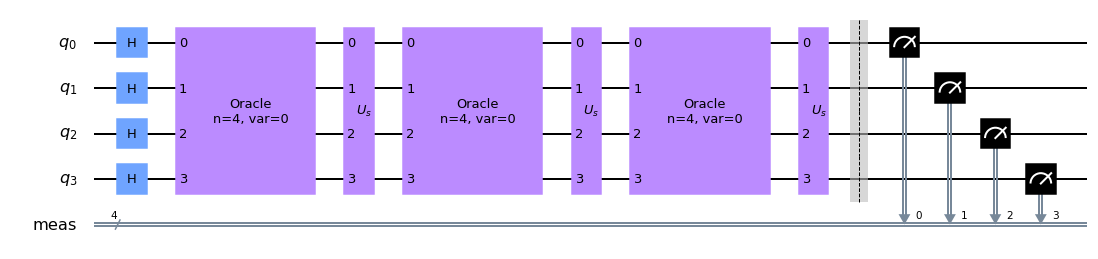

In [83]:
## Iteration x3
n = 4
variant = 0
oracle = grover_problem_oracle(n, variant, print_solutions = True)
qc = QuantumCircuit(n)
qc = initialize_s(qc, [0,1,2,3])
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.append(oracle, [0,1,2,3])
qc.append(diffuser(n), [0,1,2,3])
qc.measure_all()
qc.draw('mpl')

{'0010': 144, '0011': 157, '0110': 149, '0111': 17, '1010': 137, '1011': 23, '1110': 13, '1111': 384}


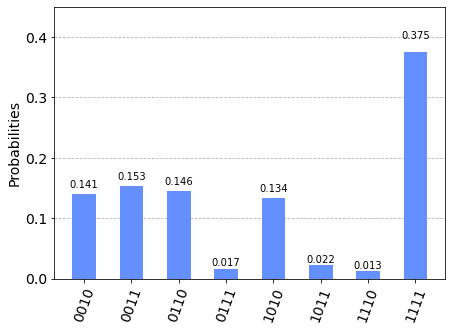

In [84]:
results = execute(qc, backend=backend, shots=1024).result().get_counts()
print(results)
plot_histogram(results)

Solutions:
|00100>


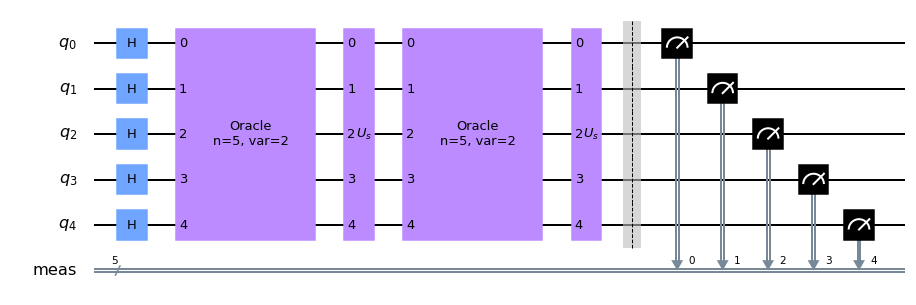

In [61]:
#Problem Two
## Iteration X2
n = 5
variant = 2
oracle = grover_problem_oracle(n, variant, print_solutions = True)
qc = QuantumCircuit(n)
qc = initialize_s(qc, [0,1,2,3,4])
qc.append(oracle, [0,1,2,3,4])
qc.append(diffuser(n), [0,1,2,3,4])
qc.append(oracle, [0,1,2,3,4])
qc.append(diffuser(n), [0,1,2,3,4])
qc.measure_all()
qc.draw('mpl')

{'00000': 10, '00001': 29, '10000': 38, '10001': 71, '10010': 65, '10011': 39, '10100': 26, '10101': 11, '10110': 4, '10111': 35, '11000': 62, '11001': 32, '11010': 37, '11011': 7, '11100': 8, '11101': 32, '11110': 28, '11111': 5, '00010': 39, '00011': 91, '00100': 7, '00101': 33, '00110': 25, '00111': 4, '01000': 30, '01001': 66, '01010': 81, '01011': 30, '01100': 34, '01101': 8, '01110': 6, '01111': 31}


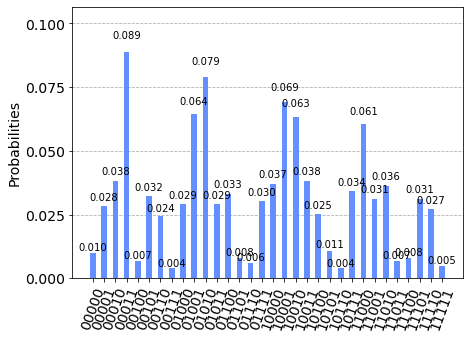

In [62]:
results = execute(qc, backend=backend, shots=1024).result().get_counts()
print(results)
plot_histogram(results)

Solutions:
|00100>


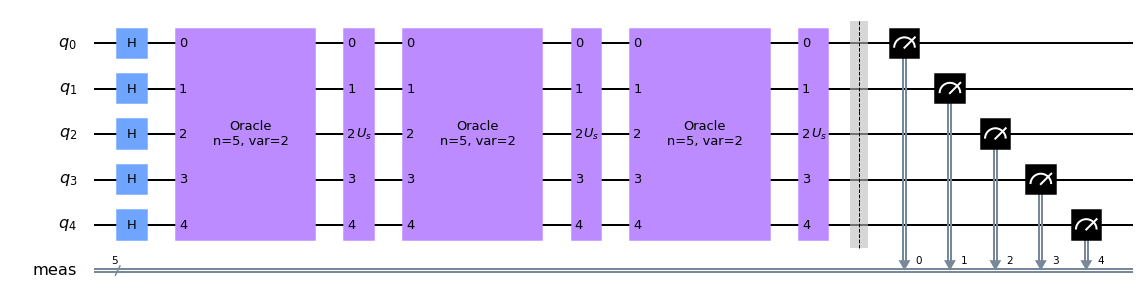

In [63]:
## Iteration X3
n = 5
variant = 2
oracle = grover_problem_oracle(n, variant, print_solutions = True)
qc = QuantumCircuit(n)
qc = initialize_s(qc, [0,1,2,3,4])
qc.append(oracle, [0,1,2,3,4])
qc.append(diffuser(n), [0,1,2,3,4])
qc.append(oracle, [0,1,2,3,4])
qc.append(diffuser(n), [0,1,2,3,4])
qc.append(oracle, [0,1,2,3,4])
qc.append(diffuser(n), [0,1,2,3,4])
qc.measure_all()
qc.draw('mpl')

{'00000': 28, '10001': 4, '10010': 7, '10101': 42, '10110': 35, '11000': 4, '11011': 34, '11100': 41, '11111': 669, '00011': 8, '00100': 34, '00111': 47, '01001': 5, '01010': 2, '01101': 27, '01110': 37}


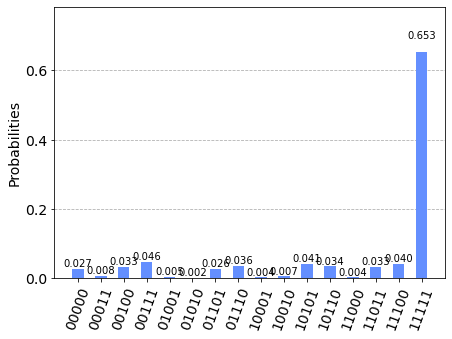

In [64]:
results = execute(qc, backend=backend, shots=1024).result().get_counts()
print(results)
plot_histogram(results)